In [1]:
import keras
from keras.applications.densenet import DenseNet121
from keras.optimizers import SGD, Adam
from keras.models import Sequential
from keras import activations, Model
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, Deconvolution2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Flatten, Dense, Dropout, Activation 
from sklearn.preprocessing import OneHotEncoder

from matplotlib.pyplot import imread
import random
from os.path import join, basename, dirname, exists  
import os  
import glob
import numpy as np
import csv
import matplotlib.pyplot as plt
from PIL import * 

/home/sebastian/anaconda2/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Dataset Setup

In [145]:
path_tupac1 = '/mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_1/'
path_tupac2 = '/mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_2/'
path_tupac3 = '/mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_3/'
PREFIX_IMGS = '/mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_'
PATH_GT = '/mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_ground_truth/'
list_tifs = glob.glob(path_tupac1 + '**/*.tif') +glob.glob(path_tupac2 + '**/*.tif')+glob.glob(path_tupac3 + '**/*.tif')
list_csv = glob.glob(PATH_GT + '**/*.csv')
print(len(list_tifs))
print(len(list_csv))
list_csv
positive_cases = []
for item in list_csv:
    num_case = int(item.split('/')[-2])
    #print(num_case)
    if num_case in range(24):
        positive_cases.append(item)
len(positive_cases)

dict_case_mitosis = d={i:[] for i in list(1+np.arange(23))}
for item in positive_cases:
    with open(item, 'rt', encoding='utf8') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',')
        num_case = int(item.split('/')[-2])
        if num_case in dict_case_mitosis.keys():
            for row in spamreader:
                dict_case_mitosis[num_case].append(row)
        else:
            dict_case_mitosis[num_case] = []
            for row in spamreader:
                dict_case_mitosis[num_case].append(row)

total_sum = 0
all_names = []
all_lengths = []
for key in dict_case_mitosis.keys():
    total_sum+=len(dict_case_mitosis[key])
    all_names.append(key)
    all_lengths.append(len(dict_case_mitosis[key]))
    #print(len(dict_case_mitosis[key]))
print(total_sum)#Total Number of mitosis
#Lafrange used 458+92+533 = 1083

656
587
1083


In [146]:
#This partitions are almost consistent with the setup of Lafrange in his paper in which the numbers per partition are ambigous...
cases_train = [1,2,4,6,8,9,11,12] #cases are 1-indexed
cases_val = [3,5,7,10] 
cases_test = [13,14,15,16,17,18,19,20,21,22,23] 
print(np.array(all_lengths)[np.array(cases_train)-1].sum())
print(np.array(all_lengths)[np.array(cases_val)-1].sum())
print(np.array(all_lengths)[np.array(cases_test)-1].sum())


458
92
533


In [101]:
# Define a function to read images from disk and convert them to xyc format in a desire output range.
def load_image(input_path, range_min=0, range_max=1):
    
    # Read image data (x, y, c) [0, 255]
    image = imread(input_path)
    
    # Convert image to the correct range
    image = (image / 255) * (range_max - range_min) + range_min 

    return image

# Define a function to plot a batch or list of image patches in a grid
def plot_image(images, images_per_row=8):
    
    fig, axs = plt.subplots(int(np.ceil(len(images)/images_per_row)), images_per_row)
    
    c = 0
    for ax_row in axs:
        for ax in ax_row:
            if c < len(images):
                ax.imshow(images[c])
            ax.axis('off')            
            c += 1
    plt.show()


In [102]:
import numbers
from skimage.util.shape import view_as_windows
from glob import iglob
import fnmatch
from numpy.lib.stride_tricks import as_strided

def extract_patches(arr, patch_shape=8, extraction_step=1):
    """Extracts patches of any n-dimensional array in place using strides.
    Given an n-dimensional array it will return a 2n-dimensional array with
    the first n dimensions indexing patch position and the last n indexing
    the patch content. This operation is immediate (O(1)). A reshape
    performed on the first n dimensions will cause numpy to copy data, leading
    to a list of extracted patches.
    Read more in the :ref:`User Guide <image_feature_extraction>`.
    Parameters
    ----------
    arr : ndarray
        n-dimensional array of which patches are to be extracted
    patch_shape : integer or tuple of length arr.ndim
        Indicates the shape of the patches to be extracted. If an
        integer is given, the shape will be a hypercube of
        sidelength given by its value.
    extraction_step : integer or tuple of length arr.ndim
        Indicates step size at which extraction shall be performed.
        If integer is given, then the step is uniform in all dimensions.
    Returns
    -------
    patches : strided ndarray
        2n-dimensional array indexing patches on first n dimensions and
        containing patches on the last n dimensions. These dimensions
        are fake, but this way no data is copied. A simple reshape invokes
        a copying operation to obtain a list of patches:
        result.reshape([-1] + list(patch_shape))
    """

    arr_ndim = arr.ndim

    if isinstance(patch_shape, numbers.Number):
        patch_shape = tuple([patch_shape] * arr_ndim)
    if isinstance(extraction_step, numbers.Number):
        extraction_step = tuple([extraction_step] * arr_ndim)

    patch_strides = arr.strides

    slices = [slice(None, None, st) for st in extraction_step]
    indexing_strides = arr[slices].strides

    patch_indices_shape = ((np.array(arr.shape) - np.array(patch_shape)) //
                           np.array(extraction_step)) + 1

    shape = tuple(list(patch_indices_shape) + list(patch_shape))
    strides = tuple(list(indexing_strides) + list(patch_strides))
    patches = as_strided(arr, shape=shape, strides=strides)
    return patches, indexing_strides, patch_indices_shape, slices

def is_white_patch(cur_patch,white_percentage):
    is_white = True
    total_white = float(cur_patch.shape[0] *cur_patch.shape[1] * cur_patch.shape[2] * 255)
    if (cur_patch.sum()/total_white)>white_percentage:
        return is_white
    else:
        return not is_white
def read_open_slide_image(path,level):
    reader = mir.MultiResolutionImageReader()
    mr_image = reader.open(path)
    ds = mr_image.getLevelDownsample(level)
    pixels = mr_image.getUCharPatch(int(1 * ds), int(1 * ds), mr_image.getLevelDimensions(level)[0], mr_image.getLevelDimensions(level)[1], level)
    return pixels

def compute_corner_patches(img_size, stride_x, stride_y):
    array_corners = []
    total_p_x,total_p_y  = 0,0
#    for i in range(0,img_size[0]-5*stride_x,stride_x): #Works for 48x48, 8 stride patches
    stride_x_corner = 0
    stride_y_corner = 0
    for i in range(0,img_size[0]-stride_x_corner*stride_x,stride_x):
        total_p_x = total_p_x +1
        corners_row = []
#        for j in range(0,img_size[1]-5*stride_y, stride_y):
        for j in range(0,img_size[1]-stride_y_corner*stride_y, stride_y):
            if i == 0:
                total_p_y = total_p_y +1
            corners_row.append((i,j))
        array_corners.append(corners_row)
    return np.array(array_corners),total_p_x,total_p_y


In [103]:
def localize_mitosis(img,pathcsv):
    coord_mitosis = []
    with open(pathcsv, 'rt', encoding='utf8') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',')
        for row in spamreader:
            coord_mitosis.append(np.array([int(row[0]),int(row[1])]))
    return coord_mitosis

def localize_mitosis_patches(pathcsv,return_img=False):
    coord_mitosis = []
    mitotic_patches = []
    num_case = int(pathcsv.split('/')[-2])
    str_case = pathcsv.split('/')[-2]
    str_hpf  = pathcsv.split('/')[-1].split('.csv')[0]
    with open(pathcsv, 'rt', encoding='utf8') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',')
        for row in spamreader:
            coord_mitosis.append(np.array([int(row[0]),int(row[1])]))
    if num_case <= 14:
        part = '1'
    if (num_case > 14) and (num_case <= 33) :
        part = '2'    
    if (num_case > 33) :
        part = '3'
    path_img = PREFIX_IMGS + part + '/' + str_case + '/' + str_hpf + '.tif'
    sampl_img = np.array(Image.open(path_img))
    for item in coord_mitosis:
        anchor_x, anchor_y = item[0]-31,  item[1]-31
        if anchor_x < 0:  
            anchor_x = 0
        if anchor_y < 0:
            anchor_y = 0          
        cur_patch =sampl_img[anchor_x:anchor_x+63,anchor_y:anchor_y+63,:] 
        mitotic_patches.append(cur_patch)
    print("Computed coords and patches for " + path_img ) 
    if return_img: 
        return coord_mitosis,mitotic_patches,sampl_img
    else:
        return coord_mitosis,mitotic_patches

In [113]:
sum_cases = 0
for i in range(len(cases_train)):
    sum_cases+=len(dict_case_mitosis[cases_train[i]])
print(sum_cases)

458


In [134]:
dict_image_csv = d={i:[] for i in list(1+np.arange(73))}
for item in list_csv:
    casenum = int(item.split('/')[-2])
    if casenum in dict_image_csv.keys():
        dict_image_csv[casenum].append(item)
    else:
        dict_image_csv[casenum] = []
print(dict_image_csv.keys())

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73])


In [135]:
dict_image_csv

{1: ['/mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_ground_truth/01/01.csv',
  '/mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_ground_truth/01/02.csv',
  '/mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_ground_truth/01/03.csv',
  '/mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_ground_truth/01/04.csv',
  '/mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_ground_truth/01/05.csv',
  '/mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_ground_truth/01/06.csv',
  '/mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_ground_truth/01/07.csv',
  '/mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_ground_truth/01/08.csv',
  '/mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_ground_truth/01/09.csv',
  '/mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_ground_truth/01/10.csv',
  '/mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_ground_truth/01/11.csv',
  '/mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_ground_truth/01/12.csv',
  '/mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mit

In [400]:
coords_patches, patches = localize_mitosis_patches(dict_image_csv[all_names[cases_train[sampl_idx_case]]][0])

Computed coords and patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_1/07/02.tif


In [136]:
print(cases_train)
print(cases_val)
print(cases_test)
print(np.array(all_lengths)[np.array(cases_test)-1])

[1, 2, 4, 6, 8, 9, 11, 12]
[3, 5, 7, 10]
[13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
[  3  16  66   9   6 212   2   0 115  72  32]


Computed coords and patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_2/23/22.tif


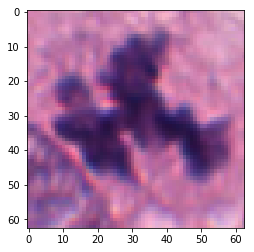

In [158]:
coords_patches, patches = localize_mitosis_patches(csv_path)
plt.imshow(patches[0])

In [178]:
pp??

In [175]:
from skimage.transform import resize
pp = resize(np.array(Image.open('/home/sebastian/15_10_1987_1437.png')),(63,63,3),mode='reflect')
#Take as example the one left in home which does not match the propper size
pp = Image.fromarray(pp)
plt.imshow(pp)

TypeError: Cannot handle this data type

In [179]:
def save_patches(csv_path,coords_patches,patches,target_dir, patch_size, incremental_prefix=False):
    for i in range(len(coords_patches)):
        cur_patch = Image.fromarray(patches[i])
        if (np.array(cur_patch).shape[0] != patch_size[0]) or (np.array(cur_patch).shape[1] != patch_size[1]):
            cur_patch = resize(np.array(cur_patch),(patch_size[0],patch_size[1],3),mode='reflect')
            cur_patch = Image.fromarray(np.uint8(cur_patch*255))
            #cur_patch = Image.fromarray(patch_size,resample=Image.LANCZOS)
        num_img = csv_path.split('/')[-2]
        num_csv = csv_path.split('/')[-1].split('.csv')[0]
        coord_x, coord_y = str(coords_patches[i][0]),  str(coords_patches[i][1])
        name_patch = num_img +'_' +num_csv + '_' + coord_x + '_' +  coord_y + '.png' 
        cur_patch.save(target_dir+name_patch)
    return

In [139]:
dict_image_csv.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73])

In [182]:
#Here is only needed to change the target dir for train/val/test accordingly 
target_dir = '/mnt/nas3/bigdatasets/Desuto/tupac_mitosis/patches/lafrange/val/mitosis/'
for sampl_idx_case in range(len(cases_val)):
    cur_case_name = cases_val[sampl_idx_case]
    for csv_num in range(len(dict_image_csv[cur_case_name])):
        csv_path = dict_image_csv[cur_case_name][csv_num]
        coords_patches, patches = localize_mitosis_patches(csv_path)
        print("Saving Patches for " + str(csv_path))
        save_patches(csv_path,coords_patches,patches,target_dir,patch_size=(63,63))

Computed coords and patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_1/03/01.tif
Saving Patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_ground_truth/03/01.csv
Computed coords and patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_1/03/02.tif
Saving Patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_ground_truth/03/02.csv
Computed coords and patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_1/03/03.tif
Saving Patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_ground_truth/03/03.csv
Computed coords and patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_1/03/04.tif
Saving Patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_ground_truth/03/04.csv
Computed coords and patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_1/03/05.tif
Saving Patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_gro

Computed coords and patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_1/07/23.tif
Saving Patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_ground_truth/07/23.csv
Computed coords and patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_1/07/24.tif
Saving Patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_ground_truth/07/24.csv
Computed coords and patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_1/07/25.tif
Saving Patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_ground_truth/07/25.csv
Computed coords and patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_1/07/26.tif
Saving Patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_ground_truth/07/26.csv
Computed coords and patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_1/07/27.tif
Saving Patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_gro

In [297]:
stride_x,stride_y = 63,63
all_patches = extract_patches(np.array(cur_p)[:,:,0], (63,63), extraction_step=stride_x)
array_corners, tpx,tpy = compute_corner_patches([np.array(cur_p).shape[0],np.array(cur_p).shape[1]],stride_x,stride_y)

In [183]:
#This problem has an important class imbalance. with this function ALL of the negatives (non-overlapped) will be extracted
# for later perform hard negative mining 
def extract_neg_patches(img,coord_positive,stride_x,stride_y, min_distance):
    neg_patches, neg_patches_coords = [],[]
    #coord_positive #= coord_positive
    possible_coord, tpx,tpy = compute_corner_patches([np.array(img).shape[0],np.array(img).shape[1]],stride_x,stride_y) 
    possible_coord = possible_coord.reshape(possible_coord.shape[0]*possible_coord.shape[1],2)
    for i in range(len(possible_coord)):
        valid_negative = True
        for j in range(len(coord_positive)):
            if np.linalg.norm(np.array(possible_coord[i])-np.array(coord_positive[j])) < min_distance:
                valid_negative = False     
        if valid_negative and j == len(coord_positive) -1:
            anchor_x, anchor_y = possible_coord[i][0]-31,  possible_coord[i][1]-31
            if anchor_x < 0:  
                anchor_x = 0
            if anchor_y < 0:
                anchor_y = 0
            neg_patches_coords.append([anchor_x, anchor_y])
            neg_patches.append(np.array(img)[anchor_x:anchor_x+63,anchor_y:anchor_y+63,:])
    return neg_patches, neg_patches_coords

In [ ]:
#Same as before here is only needed to change the target dir for train/val/test accordingly 
stride_x,stride_y,min_distance = 63,63,63
target_dir = '/mnt/nas3/bigdatasets/Desuto/tupac_mitosis/patches/lafrange/training/non_mitosis/'
coord_positive = []
for sampl_idx_case in range(len(cases_train)):
    cur_case_name =cases_train[sampl_idx_case]
    agg_coord_positive = []
    for csv_num in range(len(dict_image_csv[cur_case_name])):
        pathcsv = dict_image_csv[cur_case_name][csv_num]
        coord_positive, _, sampl_img= localize_mitosis_patches(pathcsv,return_img=True)
        neg_patches, neg_patches_coords = extract_neg_patches(sampl_img,coord_positive,stride_x,stride_y, min_distance)
        save_patches(pathcsv,neg_patches_coords,neg_patches,target_dir,patch_size=(63,63))
        #save_patches(csv_path,coords_patches,patches,target_dir,patch_size=(63,63))

Computed coords and patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_1/01/01.tif
Computed coords and patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_1/01/02.tif
Computed coords and patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_1/01/03.tif
Computed coords and patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_1/01/04.tif
Computed coords and patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_1/01/05.tif
Computed coords and patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_1/01/06.tif
Computed coords and patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_1/01/07.tif
Computed coords and patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_1/01/08.tif
Computed coords and patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_1/01/09.tif
C

Computed coords and patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_1/04/08.tif
Computed coords and patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_1/04/09.tif
Computed coords and patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_1/04/10.tif
Computed coords and patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_1/04/11.tif
Computed coords and patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_1/04/12.tif
Computed coords and patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_1/04/13.tif
Computed coords and patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_1/04/14.tif
Computed coords and patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_1/04/15.tif
Computed coords and patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_1/04/16.tif
C

Computed coords and patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_1/06/21.tif
Computed coords and patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_1/06/22.tif
Computed coords and patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_1/06/23.tif
Computed coords and patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_1/06/24.tif
Computed coords and patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_1/06/25.tif
Computed coords and patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_1/06/26.tif
Computed coords and patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_1/06/27.tif
Computed coords and patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_1/06/28.tif
Computed coords and patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_1/06/29.tif
C

In [388]:
print(cases_train)
print(cases_val)
print(cases_test)

[6, 7, 9, 12, 14, 16, 18, 20]
[0, 2, 4, 8]
[13, 1, 19, 10, 3, 5, 11, 17]


In [ ]:
#Definition of the CNN model
kernel_size = (4,4)
input_shape = (63,63,3)
nb_filters = 16 
pool_size = 2
def mitosis_model(lr,clip_norm):
    model_mitosis = Sequential() #Is sequential because all the 
    #Block 0
    model_mitosis.add(Convolution2D(nb_filters, (kernel_size[0], kernel_size[1]),
                            padding='valid',
                            input_shape=input_shape))
    model_mitosis.add(Activation('relu'))
    #Block 1
    model_mitosis.add(Convolution2D(nb_filters, (kernel_size[0], kernel_size[1]),activation='relu'))
    model_mitosis.add(BatchNormalization())
    model_mitosis.add(Activation('relu'))
    model_mitosis.add(MaxPooling2D(pool_size=pool_size))
    model_mitosis.add(Dropout(0.25))
    #Block 2
    model_mitosis.add(Convolution2D(nb_filters, (kernel_size[0], kernel_size[1]),activation='relu'))
    model_mitosis.add(BatchNormalization())
    model_mitosis.add(Activation('relu'))
    model_mitosis.add(MaxPooling2D(pool_size=pool_size))
    model_mitosis.add(Dropout(0.25))
    #Block 3
    model_mitosis.add(Convolution2D(nb_filters, (kernel_size[0], kernel_size[1]),activation='relu'))
    model_mitosis.add(BatchNormalization())
    model_mitosis.add(Activation('relu'))
    model_mitosis.add(MaxPooling2D(pool_size=pool_size))
    model_mitosis.add(Dropout(0.25))
    model_mitosis.add(Flatten())
    #Block 4
    model_mitosis.add(Dense(128))#, activation= 'relu')
    model_mitosis.add(BatchNormalization())
    model_mitosis.add(Activation('softmax'))
    model_mitosis.add(Dropout(0.25))
    model_mitosis.add(Dense(2))
    #Defining the optimizer
    sgd_opt = SGD(lr=lr, momentum=0.9, decay=0.9, nesterov=True)

    if clip_norm:
        adam_opt = Adam(lr,clipnorm=1,amsgrad=True)
    else:
        adam_opt = Adam(lr,amsgrad=True)

    model_mitosis.compile(loss='categorical_crossentropy',
              optimizer=adam_opt ,
              metrics=['mae','acc'])
    return model_mitosis

In [36]:
batch_size = 64
lambda_m = 0.01
epoch_size = 5000
Tp_min, Fp_max = 400, 100
model_mitosis = mitosis_model(lambda_m,False)

In [37]:
model_mitosis.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 60, 60, 16)        784       
_________________________________________________________________
activation_16 (Activation)   (None, 60, 60, 16)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 57, 57, 16)        4112      
_________________________________________________________________
batch_normalization_13 (Batc (None, 57, 57, 16)        64        
_________________________________________________________________
activation_17 (Activation)   (None, 57, 57, 16)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 28, 28, 16)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 28, 28, 16)        0         
__________

Building generator for patches in /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/patches/training/
(32, 63, 63, 3)
(32, 2)


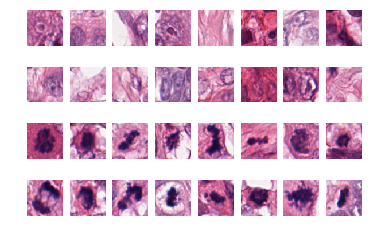

In [38]:
##Building the generators for balanced negative-positive batches

class simplePatchGenerator(object):
    def __init__(self, input_dir, batch_size, img_shape = (63,63,3), augmentation_fn=None):
        print("Building generator for patches in " + input_dir)
        # Params
        self.input_dir = input_dir  # path to patches in glob format
        self.batch_size = batch_size  # number of patches per batch
        self.augmentation_fn = augmentation_fn  # augmentation function
        self.img_shape = img_shape
        self.list_positive = glob.glob(input_dir + 'mitosis/*.png')
        self.list_negative = glob.glob(input_dir + 'non_mitosis/*.png')
        self.encoder = OneHotEncoder(sparse=False)
        

        self.n_samples = len(self.list_negative +self.list_positive)
        self.n_batches = self.n_samples // self.batch_size
    def __iter__(self):
        return self

    def __next__(self):
        return self.next()

    def __len__(self):
        # Provide length in number of batches
        return self.n_batches

    def next(self):
        # Build a mini-batch
        paths_negatives = random.sample(self.list_negative,self.batch_size//2) #self.df.loc[self.df['label'] == 0, :].sample(self.batch_size//2, replace = True)
        paths_positives = random.sample(self.list_positive,self.batch_size//2) #self.df.loc[self.df['label'] == 0, :].sample(self.batch_size//2, replace = True)
        images = []
        labels = np.concatenate((np.zeros((self.batch_size//2,1)), np.ones((self.batch_size//2,1))),axis=0)
        label_idx = 0
        for pathimg in paths_negatives+paths_positives:
            try:
                # Read image path
                # Read data and label
                image = load_image(pathimg)
                # Data augmentation
                if self.augmentation_fn:
                    image = self.augmentation_fn(image)

                # Append
                if image.shape != self.img_shape:
                    images.append(images[-1])
                    labels[label_idx] = labels[label_idx-1]
                else:
                    images.append(image)
                label_idx+=1
            except Exception as e:
                print('Failed reading img {idx}...'.format(idx=pathimg))
                print(e)
            label_idx += 1
            
        batch_x = np.stack(images).astype('float32')
        batch_y = np.stack(labels).astype('float32')

        return batch_x, self.encoder.fit_transform(batch_y)#batch_y

# Test the data generator
training_gen = simplePatchGenerator(
    input_dir='/mnt/nas3/bigdatasets/Desuto/tupac_mitosis/patches/training/', 
    batch_size=32,
    img_shape = (63,63,3)
)

for batch_x, batch_y in training_gen:
    print(batch_x.shape)
    print(batch_y.shape)
    plot_image(batch_x*255, images_per_row=8)
    break

Building generator for patches in /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/patches/val/
(32, 63, 63, 3)
(32, 2)


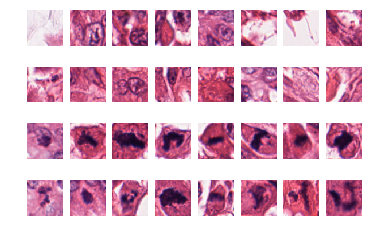

In [39]:
val_gen = simplePatchGenerator(
    input_dir='/mnt/nas3/bigdatasets/Desuto/tupac_mitosis/patches/val/', 
    batch_size=32,
    img_shape = (63,63,3)
)
for batch_x, batch_y in val_gen:
    print(batch_x.shape)
    print(batch_y.shape)
    plot_image(batch_x*255, images_per_row=8)
    break

In [40]:
#Building the hns dataset
# 1) Sampling a stratified batch of pos and neg samples
# 2) Check time of inference for hns
max_epochs = 10
for i in range(max_epochs):
    #Train patch detector on one epoch;
    model_mitosis.fit_generator(training_gen, epochs=10,verbose=1,callbacks=None, validation_data=val_gen, validation_steps=100,steps_per_epoch=500)

Epoch 1/10
500/500 [==============================] - 63s 126ms/step - loss: 0.5309 - mean_absolute_error: 0.4213 - acc: 0.8466 - val_loss: 8.0590 - val_mean_absolute_error: 0.5908 - val_acc: 0.5000
Epoch 2/10
500/500 [==============================] - 61s 123ms/step - loss: 0.3325 - mean_absolute_error: 0.3274 - acc: 0.8995 - val_loss: 1.0645 - val_mean_absolute_error: 0.4564 - val_acc: 0.5000
Epoch 3/10
500/500 [==============================] - 59s 118ms/step - loss: 0.2372 - mean_absolute_error: 0.3018 - acc: 0.9253 - val_loss: 0.9424 - val_mean_absolute_error: 0.4748 - val_acc: 0.5000
Epoch 4/10
500/500 [==============================] - 56s 111ms/step - loss: 0.2353 - mean_absolute_error: 0.2747 - acc: 0.9358 - val_loss: 0.3708 - val_mean_absolute_error: 0.2822 - val_acc: 0.8213
Epoch 5/10
500/500 [==============================] - 56s 113ms/step - loss: 0.2550 - mean_absolute_error: 0.2920 - acc: 0.9194 - val_loss: 0.5787 - val_mean_absolute_error: 0.4644 - val_acc: 0.7544
Epoch

KeyboardInterrupt: 

In [31]:
model_mitosis.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 60, 60, 16)        784       
_________________________________________________________________
activation_6 (Activation)    (None, 60, 60, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 57, 57, 16)        4112      
_________________________________________________________________
batch_normalization_5 (Batch (None, 57, 57, 16)        64        
_________________________________________________________________
activation_7 (Activation)    (None, 57, 57, 16)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 28, 28, 16)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 28, 28, 16)        0         
__________

In [428]:
generator

NameError: name 'generator' is not defined